In [4]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

### 1. Train model

#### 1.1. Describe data and split dataset

In [2]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data

In [3]:
df = describe_dataset("./dataset.csv")

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']
Number of rows: 15372 
Number of columns: 37

Labels: 
C    8238
L    7134
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


In [11]:
t = df[['nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']].apply(lambda x: pd.Series.round(x, 2))
t.to_csv("round.csv")

<AxesSubplot:xlabel='count', ylabel='label'>

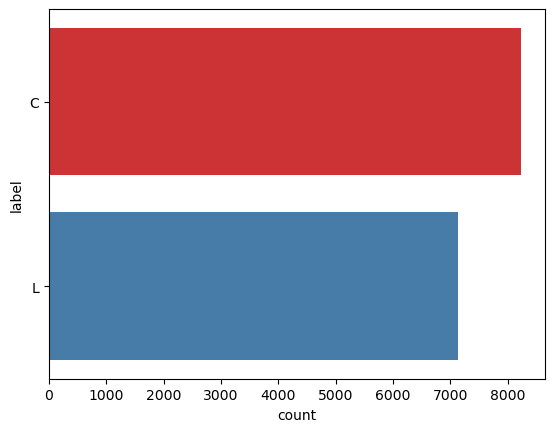

In [7]:
sns.countplot(y='label', data=df, palette="Set1")

In [35]:
# Extract features and class

X = df.drop("label", axis=1) # features
y = df["label"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
y_test.head(5)

1922     L
6789     L
8933     L
1985     L
14857    C
Name: label, dtype: object

#### 1.2. Train model using Scikit-learn

In [37]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC()),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", SGDClassifier()),
         ("Ridge", RidgeClassifier()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average="macro")
    a_score = accuracy_score(y_test, model_results)
    f1_score_result = f1_score(y_test, model_results, average=None, labels=["C", "L"])
    final_results.append(( name, p_score, a_score, f1_score_result ))


final_results.sort(key=lambda k: k[3][0] + k[3][1], reverse=True)

In [38]:
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score" , "F1 score"])

,Model,Precision Score,Accuracy score,F1 score
0,RF,0.998015,0.998049,"[0.9982053838484547, 0.9978617248752674]"
1,KNN,0.996343,0.996314,"[0.9966128710898585, 0.9959571938168846]"
2,DTC,0.991660,0.991761,"[0.9924212205823694, 0.9909738717339668]"
3,SVC,0.985142,0.985473,"[0.9866080351788926, 0.9841269841269841]"
4,Ridge,0.965267,0.966175,"[0.9685483870967742, 0.9634146341463415]"
5,SGDC,0.936102,0.935820,"[0.9383333333333332, 0.9330922242314647]"
6,LR,0.923847,0.924978,"[0.9298743413052291, 0.9193473193473194]"


#### 1.3. Dump model pickle

In [39]:
with open("./model/RF_model.pkl", "wb") as f:
    pickle.dump(models["RF"], f)

In [40]:
with open("./model/KNN_model.pkl", "wb") as f:
    pickle.dump(models["KNN"], f)